# First-Order System PINN (FO-PINN) for High-Order PDEs

### 1. Introduction: The Challenge of High-Order Derivatives

Standard PINNs rely on automatic differentiation to compute PDE residuals. When dealing with high-order PDEs (e.g., 3rd, 4th, or higher order), this can lead to significant challenges:
-   **Vanishing/Exploding Gradients:** Backpropagating through deep computational graphs involving high-order derivatives can lead to unstable gradients, making training difficult.
-   **Computational Cost:** Calculating high-order derivatives is computationally expensive and scales poorly.
-   **Network Strain:** A single neural network struggles to accurately approximate a function and its high-order derivatives simultaneously.

The **First-Order System PINN (FO-PINN)** approach provides an elegant solution. The core idea is to **reduce the order of the PDE** by reformulating it into a coupled system of lower-order equations. This is achieved by introducing auxiliary variables.

### 2. Demonstration: 4th-Order Biharmonic Equation

This notebook demonstrates this concept by solving the 4th-order biharmonic equation:
$$ \nabla^4 u = f(x, y) $$
Instead of tackling this 4th-order PDE directly, we introduce an auxiliary variable, $w$, defined as:
$$ w = \nabla^2 u $$
This allows us to rewrite the original 4th-order equation as a system of two coupled 2nd-order Poisson's equations:
$$ \begin{cases} \nabla^2 u - w = 0 \\ \nabla^2 w = f(x, y) \end{cases} $$
Now, we can train a PINN with **two outputs** (one for $u$ and one for $w$) to solve this much more stable and computationally friendly system.

**Problem Details:**
-   **Domain:** $\Omega = [-1, 1] \times [-1, 1]$
-   **Source Function:** $f(x, y) = -4 \pi^4 \sin(\pi x) \sin(\pi y)$
-   **Analytical Solution:** $u(x, y) = \sin(\pi x) \sin(\pi y)$
-   **Boundary Conditions:** $u = 0$ and $w = \nabla^2 u = 0$ on the boundary.


In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Set backend to PyTorch for this example if needed
# dde.config.set_default_backend("pytorch")


Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


### Step 1: Define Geometry and PDE System

First, we define the 2D rectangular domain.

Next, we implement the `pde_system` function. This is the core of the FO-PINN approach. The function takes the network's output `y` and splits it into two parts:
-   `u = y[:, 0:1]`: The primary variable we want to solve for.
-   `w = y[:, 1:2]`: The auxiliary variable representing the Laplacian of `u`.

Inside the function, we compute the Laplacians of both `u` and `w` and return the two residuals corresponding to our system of equations. We also define the analytical solutions for both `u` and `w` which will be used for validation and calculating the error metric.


In [2]:
# 1. Define Geometry
geom = dde.geometry.Rectangle([-1, -1], [1, 1])

# Source function f(x, y)
# Ensure robustness for different backend tensor types.
def source_function(x):
    if dde.backend.backend_name == "pytorch":
        sin = dde.backend.sin
    else: # tensorflow or jax
        sin = np.sin
    return -4 * (np.pi**4) * sin(np.pi * x[:, 0:1]) * sin(np.pi * x[:, 1:2])

# 2. Define the PDE system (Weak Form Analogue)
# We introduce an auxiliary variable w = nabla^2 u.
# The 4th-order PDE nabla^4 u = f becomes a system of two 2nd-order PDEs:
# PDE1: nabla^2 u - w = 0
# PDE2: nabla^2 w - f = 0
# The network will have two outputs: u (output 0) and w (output 1).
def pde_system(x, y):
    """
    Defines the system of two 2nd-order PDEs.
    y is the network output, where y[:, 0:1] is u and y[:, 1:2] is w.
    """
    u, w = y[:, 0:1], y[:, 1:2]
    
    # Laplacian of u
    laplacian_u = dde.grad.hessian(u, x, i=0, j=0) + dde.grad.hessian(u, x, i=1, j=1)
    # Laplacian of w
    laplacian_w = dde.grad.hessian(w, x, i=0, j=0) + dde.grad.hessian(w, x, i=1, j=1)
    
    f = source_function(x)
    
    pde1 = laplacian_u - w
    pde2 = laplacian_w - f
    
    return [pde1, pde2]

# Analytical solution for validation
def analytical_solution(x):
    # Use np.sin as this is for validation on NumPy arrays
    return np.sin(np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])

# Analytical for w = nabla^2 u
def analytical_w(x):
    # nabla^2(sin(pi*x)sin(pi*y)) = -2*pi^2*sin(pi*x)sin(pi*y)
    return -2 * (np.pi**2) * np.sin(np.pi * x[:, 0:1]) * np.sin(np.pi * x[:, 1:2])


### Step 2: Define Boundary Conditions

Since our PDE system involves two variables (`u` and `w`), we need to define boundary conditions for both.

-   **BC for `u`:** We have a simple Dirichlet condition, $u=0$ on the boundary. We specify `component=0` to apply this condition to the first output of the network.
-   **BC for `w`:** From the problem definition, we also have a condition on the Laplacian of `u` at the boundary, $\nabla^2 u = 0$. Since we defined $w = \nabla^2 u$, this translates directly to a Dirichlet condition for `w`, i.e., $w=0$ on the boundary. We specify `component=1` to apply this to the second output of the network.


In [3]:
def boundary_func(x, on_boundary):
    return on_boundary

# 3. Define Boundary Conditions
# We have two variables (u, w) and thus need BCs for both.

# BC for u: u = 0 on the boundary (applied to the 0-th component of the network output)
bc_u = dde.DirichletBC(geom, lambda x: 0, boundary_func, component=0)

# BC for w: w = nabla^2 u = 0 on the boundary (applied to the 1-st component)
bc_w = dde.DirichletBC(geom, lambda x: 0, boundary_func, component=1)


### Step 3: Assemble, Train, and Visualize

With the geometry, PDE system, and boundary conditions defined, we can now assemble the `dde.data.PDE` object and the neural network.

-   **Data Object:** We pass the `pde_system` and the list of boundary conditions `[bc_u, bc_w]`.
-   **Network:** The network architecture must reflect our problem. It has 2 inputs (`x`, `y`) and **2 outputs** (`u`, `w`).
-   **Training:** The training process is standard. We compile with the Adam optimizer and train for a sufficient number of iterations.
-   **Visualization:** After training, we extract the predicted solution for `u` (the first output of the network) and plot it alongside the analytical solution and the absolute error to assess the accuracy of the FO-PINN model.


Compiling model...
'compile' took 10.991543 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [6.05e-02, 3.65e+04, 1.58e-01, 3.53e-02]    [5.64e-02, 4.04e+04, 1.58e-01, 3.53e-02]    []  
1000      [7.44e-01, 3.21e+00, 8.24e-02, 7.28e+00]    [6.17e-01, 2.85e+00, 8.24e-02, 7.28e+00]    []  
2000      [1.77e-01, 1.16e+00, 1.83e-02, 2.97e+00]    [1.34e-01, 1.03e+00, 1.83e-02, 2.97e+00]    []  
3000      [8.20e-02, 6.38e-01, 1.09e-02, 2.00e+00]    [6.02e-02, 5.63e-01, 1.09e-02, 2.00e+00]    []  
4000      [4.87e-02, 7.55e-01, 7.21e-03, 1.38e+00]    [3.38e-02, 6.31e-01, 7.21e-03, 1.38e+00]    []  
5000      [3.37e-02, 3.12e-01, 4.85e-03, 1.01e+00]    [2.12e-02, 2.31e-01, 4.85e-03, 1.01e+00]    []  
6000      [2.88e-02, 5.22e-01, 3.50e-03, 7.63e-01]    [1.71e-02, 4.31e-01, 3.50e-03, 7.63e-01]    []  
7000      [2.38e-02, 4.74e-01, 2.70e-03, 6.03e-01]    [1.24e-02, 4.09e-01, 2.70e-03, 6.03e-01]    []  


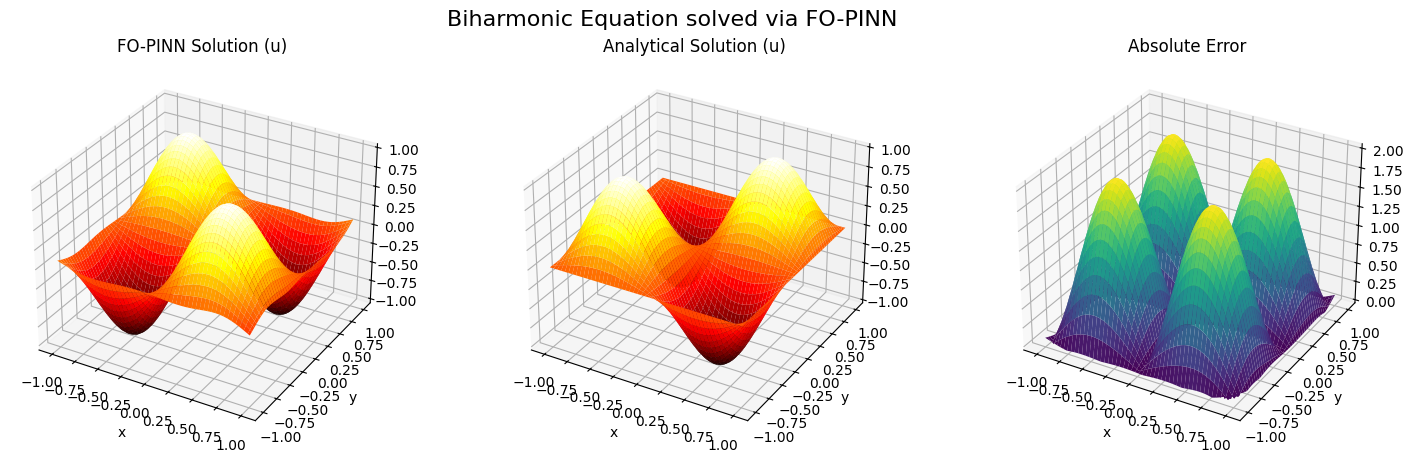

In [4]:
# 4. Assemble and Train the Model
data = dde.data.PDE(
    geom,
    pde_system,
    [bc_u, bc_w],
    num_domain=2500,
    num_boundary=100,
    solution=analytical_solution,
    num_test=1000,
)

# Network architecture: 2 inputs (x,y), 4 hidden layers, 2 outputs (u,w)
net = dde.nn.FNN([2] + [64] * 4 + [2], "tanh", "Glorot normal")

model = dde.Model(data, net)
model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=20000)

# 5. Visualize the Solution
print("\n--- Visualizing the solution for u(x,y) ---")
X = np.linspace(-1, 1, 100)
Y = np.linspace(-1, 1, 100)
X_grid, Y_grid = np.meshgrid(X, Y)
xy_test = np.vstack((X_grid.flatten(), Y_grid.flatten())).T

# Predict both u and w
y_pred = model.predict(xy_test)
u_pred = y_pred[:, 0].reshape(100, 100)
w_pred = y_pred[:, 1].reshape(100, 100) # For potential further analysis

# Get analytical solution for comparison
u_analytical = analytical_solution(xy_test).reshape(100, 100)

# Calculate and print L2 relative error
l2_error = dde.metrics.l2_relative_error(u_analytical, u_pred)
print(f"L2 relative error for u: {l2_error:.4e}")

# Plotting
fig = plt.figure(figsize=(18, 5))
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(X_grid, Y_grid, u_pred, cmap='hot')
ax1.set_title('FO-PINN Solution (u)')
ax1.set_xlabel('x'); ax1.set_ylabel('y')

ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(X_grid, Y_grid, u_analytical, cmap='hot')
ax2.set_title('Analytical Solution (u)')
ax2.set_xlabel('x'); ax2.set_ylabel('y')


ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_surface(X_grid, Y_grid, np.abs(u_pred - u_analytical), cmap='viridis')
ax3.set_title('Absolute Error')
ax3.set_xlabel('x'); ax3.set_ylabel('y')

plt.suptitle("Biharmonic Equation solved via FO-PINN", fontsize=16)
plt.show()


We have now successfully solved a 4th-order PDE by reformulating it as a system of 2nd-order PDEs and training a single neural network with two outputs. The 3D plots clearly show that the FO-PINN solution closely matches the analytical solution, demonstrating the effectiveness of this order-reduction technique.
